In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [3]:
import pandas as pd, numpy as np
from db_queries import get_outputs as go, get_ids
from vivarium import Artifact

In [4]:
!whoami
!date

nicoly
Wed Jun 30 04:11:44 PDT 2021


# Caluculate wasting category-specific mortality hazards

In [4]:
#Goal:

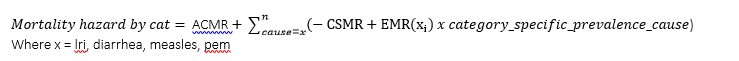

In [5]:
# need cat-specific cause prevalences

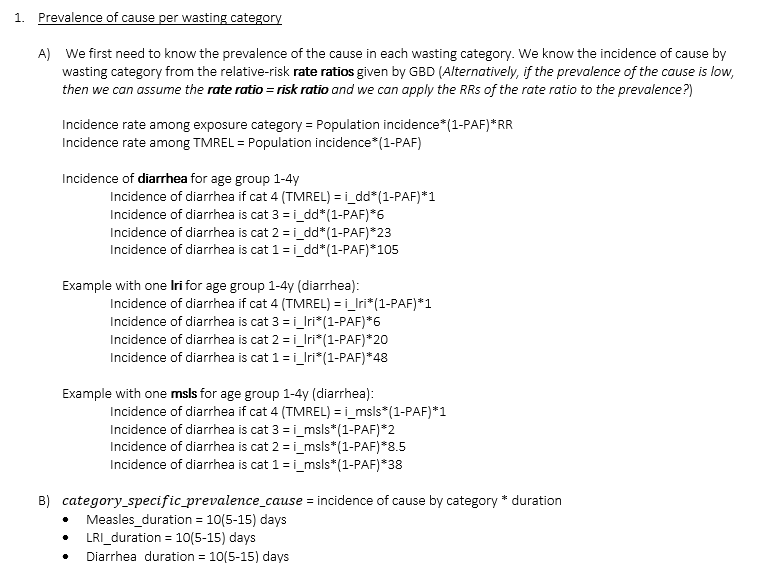

In [6]:
# https://www.thelancet.com/cms/10.1016/S0140-6736(20)30752-2/attachment/54711c7c-216e-485e-9943-8c6e25648e1e/mmc1.pdf

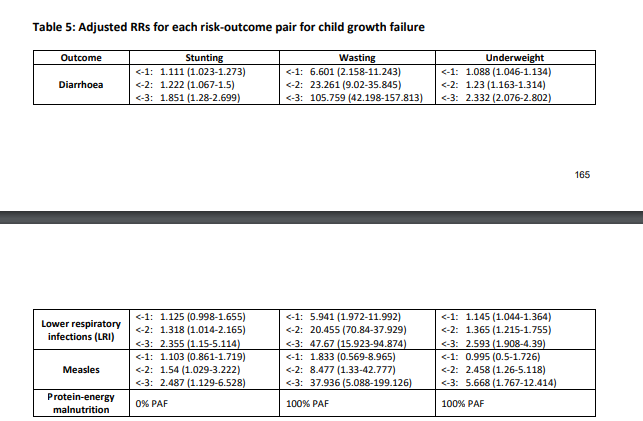

In [7]:
causes = ['diarrhea','lri','measles','pem']

In [8]:
# populate a dict of all RRs of {cause} given wasting cat
## risk among exposed / risk among unexposed
rrs = {i:{} for i in causes}

rrs['diarrhea'] = {
    'cat4':1, #tmrel
    'cat3':6.601,
    'cat2':23.261,
    'cat1':105.759,
}

rrs['lri'] = {
    'cat4':1, #tmrel
    'cat3':5.941,
    'cat2':20.455,
    'cat1':47.67,
}

rrs['measles'] = {
    'cat4':1, #tmrel
    'cat3':1.833,
    'cat2':8.477,
    'cat1':37.936,
}

# ----we don't need to use RRs for PEM-----------------

rrs['pem'] = {
    'cat4':np.infty, #tmrel = risk amonge exposed / risk among unexposed = 0 / 0
    'cat3':np.infty,
    'cat2':np.infty,
    'cat1':np.infty,   
}

## PULL DATA

In [9]:
cause_ids = get_ids("cause")

### Pulling PAFs 

In [5]:
# pull pafs - we won't use these as GBD doesnt have the PAFs we want
wasting_pafs = go(
    topic="rei",
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    gbd_round_id=6,
    age_group_id=[4,5],
    sex_id=[1,2,3],
    year_id=2019,
    rei_id=[240], 
    decomp_step="step5",
    measure_id='all',
    metric_id=2,
    location_id=179
)

In [12]:
# we only have PAFs for DALYs, deaths, and YLLs. no YLDs?
wasting_pafs.loc[
    (wasting_pafs.sex_id==3) &
    (wasting_pafs.age_group_id==5) &
    (wasting_pafs.val.notna()) &
    (wasting_pafs.val.notna()),
    ['age_group_name','measure_name','rei_name','cause_name','val','upper','lower']
].sort_values(['age_group_name','cause_name','measure_name']).set_index(
['rei_name','age_group_name','cause_name','measure_name'])

val  \
rei_name      age_group_name cause_name                   measure_name                                       
Child wasting 1 to 4         Diarrheal diseases           DALYs (Disability-Adjusted Life Years)  0.776812   
                                                          Deaths                                  0.809888   
                                                          YLLs (Years of Life Lost)               0.809888   
                             Lower respiratory infections DALYs (Disability-Adjusted Life Years)  0.748334   
                                                          Deaths                                  0.750871   
                                                          YLLs (Years of Life Lost)               0.750873   
                             Measles                      DALYs (Disability-Adjusted Life Years)  0.356713   
                                                          Deaths                                  0.357627   
                                                          YLLs (Years of Life Lost)               0.357629   
                             Protein-energy malnutrition  DALYs (Disability-Adjusted Life Years)  1.000000   
                                                          Deaths                                  1.000000   
                                                          YLDs (Years Lived with Disability)      1.000000   
                                                          YLLs (Years of Life Lost)               1.000000   

                                                                                                     upper  \
rei_name      age_group_name cause_name                   measure_name                                       
Child wasting 1 to 4         Diarrheal diseases           DALYs (Disability-Adjusted Life Years)  0.849868   
                                                          Deaths                                  0.882417   
                                                          YLLs (Years of Life Lost)               0.882417   
                             Lower respiratory infections DALYs (Disability-Adjusted Life Years)  0.875895   
                                                          Deaths                                  0.879240   
                                                          YLLs (Years of Life Lost)               0.879241   
                             Measles                      DALYs (Disability-Adjusted Life Years)  0.895855   
                                                          Deaths                                  0.897853   
                                                          YLLs (Years of Life Lost)               0.897854   
                             Protein-energy malnutrition  DALYs (Disability-Adjusted Life Years)  1.000000   
                                                          Deaths                                  1.000000   
                                                          YLDs (Years Lived with Disability)      1.000000   
                                                          YLLs (Years of Life Lost)               1.000000   

                                                                                                     lower  
rei_name      age_group_name cause_name                   measure_name                                      
Child wasting 1 to 4         Diarrheal diseases           DALYs (Disability-Adjusted Life Years)  0.594119  
                                                          Deaths                                  0.623329  
                                                          YLLs (Years of Life Lost)               0.623330  
                             Lower respiratory infections DALYs (Disability-Adjusted Life Years)  0.512218  
                                                          Deaths                                  0.514513  
                                      

### NOTE: for PAF of {cause} attributable to {risk=wasting}, because the risk category does not affect the cause duration (or EMR?), we can assume the incidence PAF == prevalence PAF. Thus we will use the GBD Deaths PAF, above. however, we include below how we would hand-calculate the PAF using the exposure category prevalences and RRs

### The PAF we want: 
#### the proportional reduction of cause (prevalence) that would occur if wasting cat1, 2, or 3 were to be reduced to cat 4 (tmrel).

We use this equation for PAF
$$ \frac{Pcat\times(RRc-1)}{Pcat\times(RRc-1)+1} = PAF \ $$

OR 

$$ \frac{\sum(Pcat)\times(RRcat)-1}{\sum(Pcat)\times(RRcat)} = PAF \ $$

### Pulling incidence

In [23]:
# pull incidence
cause_inc = go(
    topic="cause",
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    gbd_round_id=6,
    age_group_id=[4,5],
    sex_id=[1,2,3],
    year_id=2019,
    decomp_step="step5",
    measure_id=6, #incidence
    metric_id=3, #rate
    location_id=179
)

In [24]:
cause_inc.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower
0,4,322,179,6,3,1,2019,lri,Post Neonatal,Lower respiratory infections,False,Ethiopia,admin0,Incidence,Rate,Male,0.090151,0.116393,0.068537
1,4,322,179,6,3,2,2019,lri,Post Neonatal,Lower respiratory infections,False,Ethiopia,admin0,Incidence,Rate,Female,0.093498,0.119482,0.071913
2,4,322,179,6,3,3,2019,lri,Post Neonatal,Lower respiratory infections,False,Ethiopia,admin0,Incidence,Rate,Both,0.091784,0.118401,0.070490
3,4,302,179,6,3,1,2019,diarrhea,Post Neonatal,Diarrheal diseases,False,Ethiopia,admin0,Incidence,Rate,Male,2.767624,3.326221,2.251194
4,4,302,179,6,3,2,2019,diarrhea,Post Neonatal,Diarrheal diseases,False,Ethiopia,admin0,Incidence,Rate,Female,2.779747,3.354783,2.267587


### Pulling CSMR 

In [25]:
#pull csmr
csmr_df = go(
    "cause", 
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    location_id=179, 
    metric_id=3, 
    year_id=2019, 
    age_group_id=[4,5], 
    measure_id=1, 
    sex_id=[1,2,3], 
    gbd_round_id = 6,
    decomp_step='step5',
    version='latest',
)

csmr_df = csmr_df[
    ['cause_id','cause_name','age_group_id',
     'metric_name','sex_id','val','upper','lower']
].sort_values(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
).set_index(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
)

### Pulling prevalence

In [26]:
# pull prev (for emr)
prev_df = go(
    "cause", 
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    location_id=179, 
    metric_id=3, 
    year_id=2019, 
    age_group_id=[4,5], 
    measure_id=5, 
    sex_id=[1,2,3], 
    gbd_round_id = 6,
    decomp_step='step5',
    version='latest',
)

prev_df = prev_df[
    ['cause_id','cause_name','age_group_id',
     'metric_name','sex_id','val','upper','lower']
].sort_values(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
).set_index(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
)

In [27]:
prev_df.head()

val  \
metric_name cause_id cause_name         sex_id age_group_id             
Rate        302      Diarrheal diseases 1      4             0.045568   
                                               5             0.026452   
                                        2      4             0.045650   
                                               5             0.026259   
                                        3      4             0.045608   

                                                                upper  \
metric_name cause_id cause_name         sex_id age_group_id             
Rate        302      Diarrheal diseases 1      4             0.053138   
                                               5             0.033044   
                                        2      4             0.053132   
                                               5             0.033100   
                                        3      4             0.052980   

                                                                lower  
metric_name cause_id cause_name         sex_id age_group_id            
Rate        302      Diarrheal diseases 1      4             0.038577  
                                               5             0.020762  
                                        2      4             0.038413  
                                               5             0.020612  
                                        3      4             0.038552

### Calculating EMR 

In [28]:
# calculate emr
emr_df = csmr_df / prev_df

### Pulling ACMR

In [29]:
# pull acmr
acmr_df = go(
    "cause", 
    cause_id=294, #all causes
    location_id=179, 
    metric_id=3, 
    year_id=2019, 
    age_group_id=[4,5], 
    measure_id=1, 
    sex_id=[1,2,3], 
    gbd_round_id = 6,
    decomp_step='step5',
    version='latest',
)

acmr_df = acmr_df[
    ['cause_id','cause_name','age_group_id',
     'metric_name','sex_id','val','upper','lower']
].sort_values(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
).set_index(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
)

### Pulling wasting cat exposure - from ARTIFACT

#### NOTE: we comment this out here because we are using the GBD Deaths PAF instead of our calculated one

In [32]:
# #pulling from artifact - how to pull centrally from GBD? 
# art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf', filter_terms=['year_start == 2019', 'age_start <  0.076712', f'age_end <= 5'])


# art_wasting_exp = art.load('risk_factor.child_wasting.exposure').reset_index()
# art_wasting_exp.head()

In [33]:
# art_wasting_exp['mean'] = art_wasting_exp.iloc[:, 5:].mean(axis=1)
# art_wasting_exp.head()

In [34]:
# wasting_exp = art_wasting_exp[['sex', 'age_start', 'age_end', 'year_start', 'year_end', 'parameter', 'mean']]
# wasting_exp.head()

In [35]:
# wasting_exp['sex_id'] = np.where(wasting_exp['sex'] == 'Male', 1, 2)
# wasting_exp['age_group_id'] = np.where(wasting_exp['age_start'] == 0, 4, 5) 

In [37]:
# wasting_exp

In [38]:
# prev_cat = float(wasting_exp[(wasting_exp.sex_id==2) & (wasting_exp.age_group_id==4) & (wasting_exp.parameter == 'cat1')]['mean'])
# prev_cat

In [39]:
emr_df = emr_df.reset_index()
csmr_df = csmr_df.reset_index()
prev_df = prev_df.reset_index()
acmr_df = acmr_df.reset_index()

## DEFINE FNS

In [43]:
def get_cat_specific_inc(cause, cat, sex_id, age_group_id):
    
    #get cause id
    cause_map = {
        'diarrhea':302,
        'lri':322,
        'measles':341,
        'pem':387
    }
    cause_id = cause_map[cause]
    
    duration = 10 #days (TODO: check same for diarrhea, lri, measles)
    
    paf = float(wasting_pafs.loc[
        (wasting_pafs.sex_id==sex_id) &
        (wasting_pafs.cause_id==cause_id) &
        (wasting_pafs.age_group_id==age_group_id) &
        (wasting_pafs.measure_id==1)].val) #deaths
    
#---------------------------------------------------------------------------------------------------------------------------
#     This is how we derive pafs based on the category specific prevalence of the cause and RR, but we will instead use the GBD deaths paf
    
#     prev_cat1= float(wasting_exp[(wasting_exp.sex_id == sex_id) & (wasting_exp.age_group_id == age_group_id) & (wasting_exp.parameter == 'cat1')]['mean'])
#     prev_cat2= float(wasting_exp[(wasting_exp.sex_id == sex_id) & (wasting_exp.age_group_id == age_group_id) & (wasting_exp.parameter == 'cat2')]['mean'])
#     prev_cat3= float(wasting_exp[(wasting_exp.sex_id == sex_id) & (wasting_exp.age_group_id == age_group_id) & (wasting_exp.parameter == 'cat3')]['mean']) 
#     prev_cat4= float(wasting_exp[(wasting_exp.sex_id == sex_id) & (wasting_exp.age_group_id == age_group_id) & (wasting_exp.parameter == 'cat4')]['mean'])
    
#     #can we derive the PAF for cause? 
#     paf = (prev_cat1*rrs[cause]['cat1'] + prev_cat2*rrs[cause]['cat2'] + prev_cat3*rrs[cause]['cat3'] + prev_cat4*rrs[cause]['cat4'] - 1)/(prev_cat1*rrs[cause]['cat1'] + prev_cat2*rrs[cause]['cat2'] + prev_cat3*rrs[cause]['cat3'] + prev_cat4*rrs[cause]['cat4'])
#     print('PAF = ' + str(paf))
#     #(p_cat1*rr_1 + p_cat2*rr_2 + p_cat3*rr_3 + p_cat4*rr_4 - 1)/(p_cat1*rr_1 + p_cat2*rr_2 + p_cat3*rr_3 + p_cat4*rr_4)
#---------------------------------------------------------------------------------------------------------------------------
    inc = float(cause_inc[
            (cause_inc.sex_id==sex_id) &
            (cause_inc.cause_id==cause_id) &
            (cause_inc.age_group_id==age_group_id)].val)
    
#     print('wasting pop incidence (' + cause + ') = ' + str(inc))
#     print('incidence of '  + cause + ' among ' + cat + ' in cases/person-year = ')
    
    return inc*(1-paf)*rrs[cause][cat]

In [49]:
# what metric is this? incident cases / person-year?
# ya, I think so, cases/person-year

[get_cat_specific_inc('diarrhea', cat, 2, 4) for cat in ['cat1','cat2','cat3','cat4']]

[32.0397046371843, 7.046923378299189, 1.9997739228817741, 0.3029501473839985]

In [50]:
def get_cat_specific_prev(cause, cat, sex_id, age_group_id):
    duration = 10 #days. TODO: check that this is true across measles, lri, diarrhea
    return duration * get_cat_specific_inc(cause, cat, sex_id, age_group_id)

In [51]:
def get_cat_specific_mortality_hazard(cat, sex_id, age_group_id):
    
    """
    calculates:
    mortality_{cat 1&2}: acmr + sum([(emr_i*prev_i - cmsr_i) for i in diar,lri,msl]) + (emr_pem*1 - cmsr_pem)
    mortality_{cat 3&4}: acmr + sum([(emr_i*prev_i - cmsr_i) for i in diar,lri,msl]) - (cmsr_pem)
    """
    
    ## initialize vars
    mortality = 0    
    cause_id_map = {302: 'diarrhea', 322: 'lri', 341: 'measles', 387: 'pem'}
    causes = cause_id_map.keys()
    
    ## pull acmr
    acmr = float(acmr_df.loc[        
        (acmr_df.age_group_id==age_group_id) &
        (acmr_df.sex_id==sex_id)].val)
    
    # add ACMR to mortality
    mortality += acmr

    # for each cause
    for cause_id in causes:    
        csmr = float(csmr_df.loc[            
            (csmr_df.age_group_id==age_group_id) &
            (csmr_df.sex_id==sex_id) &
            (csmr_df.cause_id==cause_id)].val)
        emr = float(emr_df.loc[
            (emr_df.age_group_id==age_group_id) &
            (emr_df.sex_id==sex_id) &
            (emr_df.cause_id==cause_id)].val)
        
        # if PEM, we only add emr for cat1/2. in this case, we add all PEM EMR
        if cause_id==397:
            if cat in ['cat1','cat2']:
                mortality += -1*csmr + emr
                
        # if not PEM, add -csmr(cause) + prev-weighted emr(cause)
        else:
            cause = cause_id_map[cause_id]
            prev = get_cat_specific_prev(cause, cat, sex_id, age_group_id)
            mortality += -1*csmr + emr*prev
        
    return (1 - np.exp(-1*mortality * 1/365))

In [54]:
# is this what we expected?

[get_cat_specific_mortality_hazard(cat = cat, sex_id = 2, age_group_id = 4) for cat in ['cat1','cat2','cat3','cat4']]

[0.07694508246990339,
 0.02094247729318366,
 0.006014960620569054,
 0.0010057402946603844]

## RESULTS

In [55]:
#populate df of mortality hazards
df = pd.DataFrame(
    [(sex_id, age_group_id, cat,
      get_cat_specific_mortality_hazard(cat,sex_id,age_group_id))
     for sex_id in [1,2]
     for age_group_id in [4,5]
     for cat in ['cat1','cat2','cat3','cat4']],
    columns = ['sex_id','age_group_id','cat','mortality_hazard']
)

In [56]:
df

,sex_id,age_group_id,cat,mortality_hazard
0,1,4,cat1,0.104866
1,1,4,cat2,0.027810
2,1,4,cat3,0.007995
3,1,4,cat4,0.001323
4,1,5,cat1,0.044920
5,1,5,cat2,0.011454
6,1,5,cat3,0.003236
7,1,5,cat4,0.000575
8,2,4,cat1,0.076945
9,2,4,cat2,0.020942
